# Modelling : Decision Tree

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.simplefilter("ignore")

In [3]:
data = pd.read_csv("cleaned_data.csv")
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [4]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [5]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X , y , random_state = 12 , train_size = 0.8)


**Baseline model**

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

base_dt = DecisionTreeClassifier()

base_dt.fit(X_train , y_train) 

DecisionTreeClassifier()

**Drawing Decision Tree**

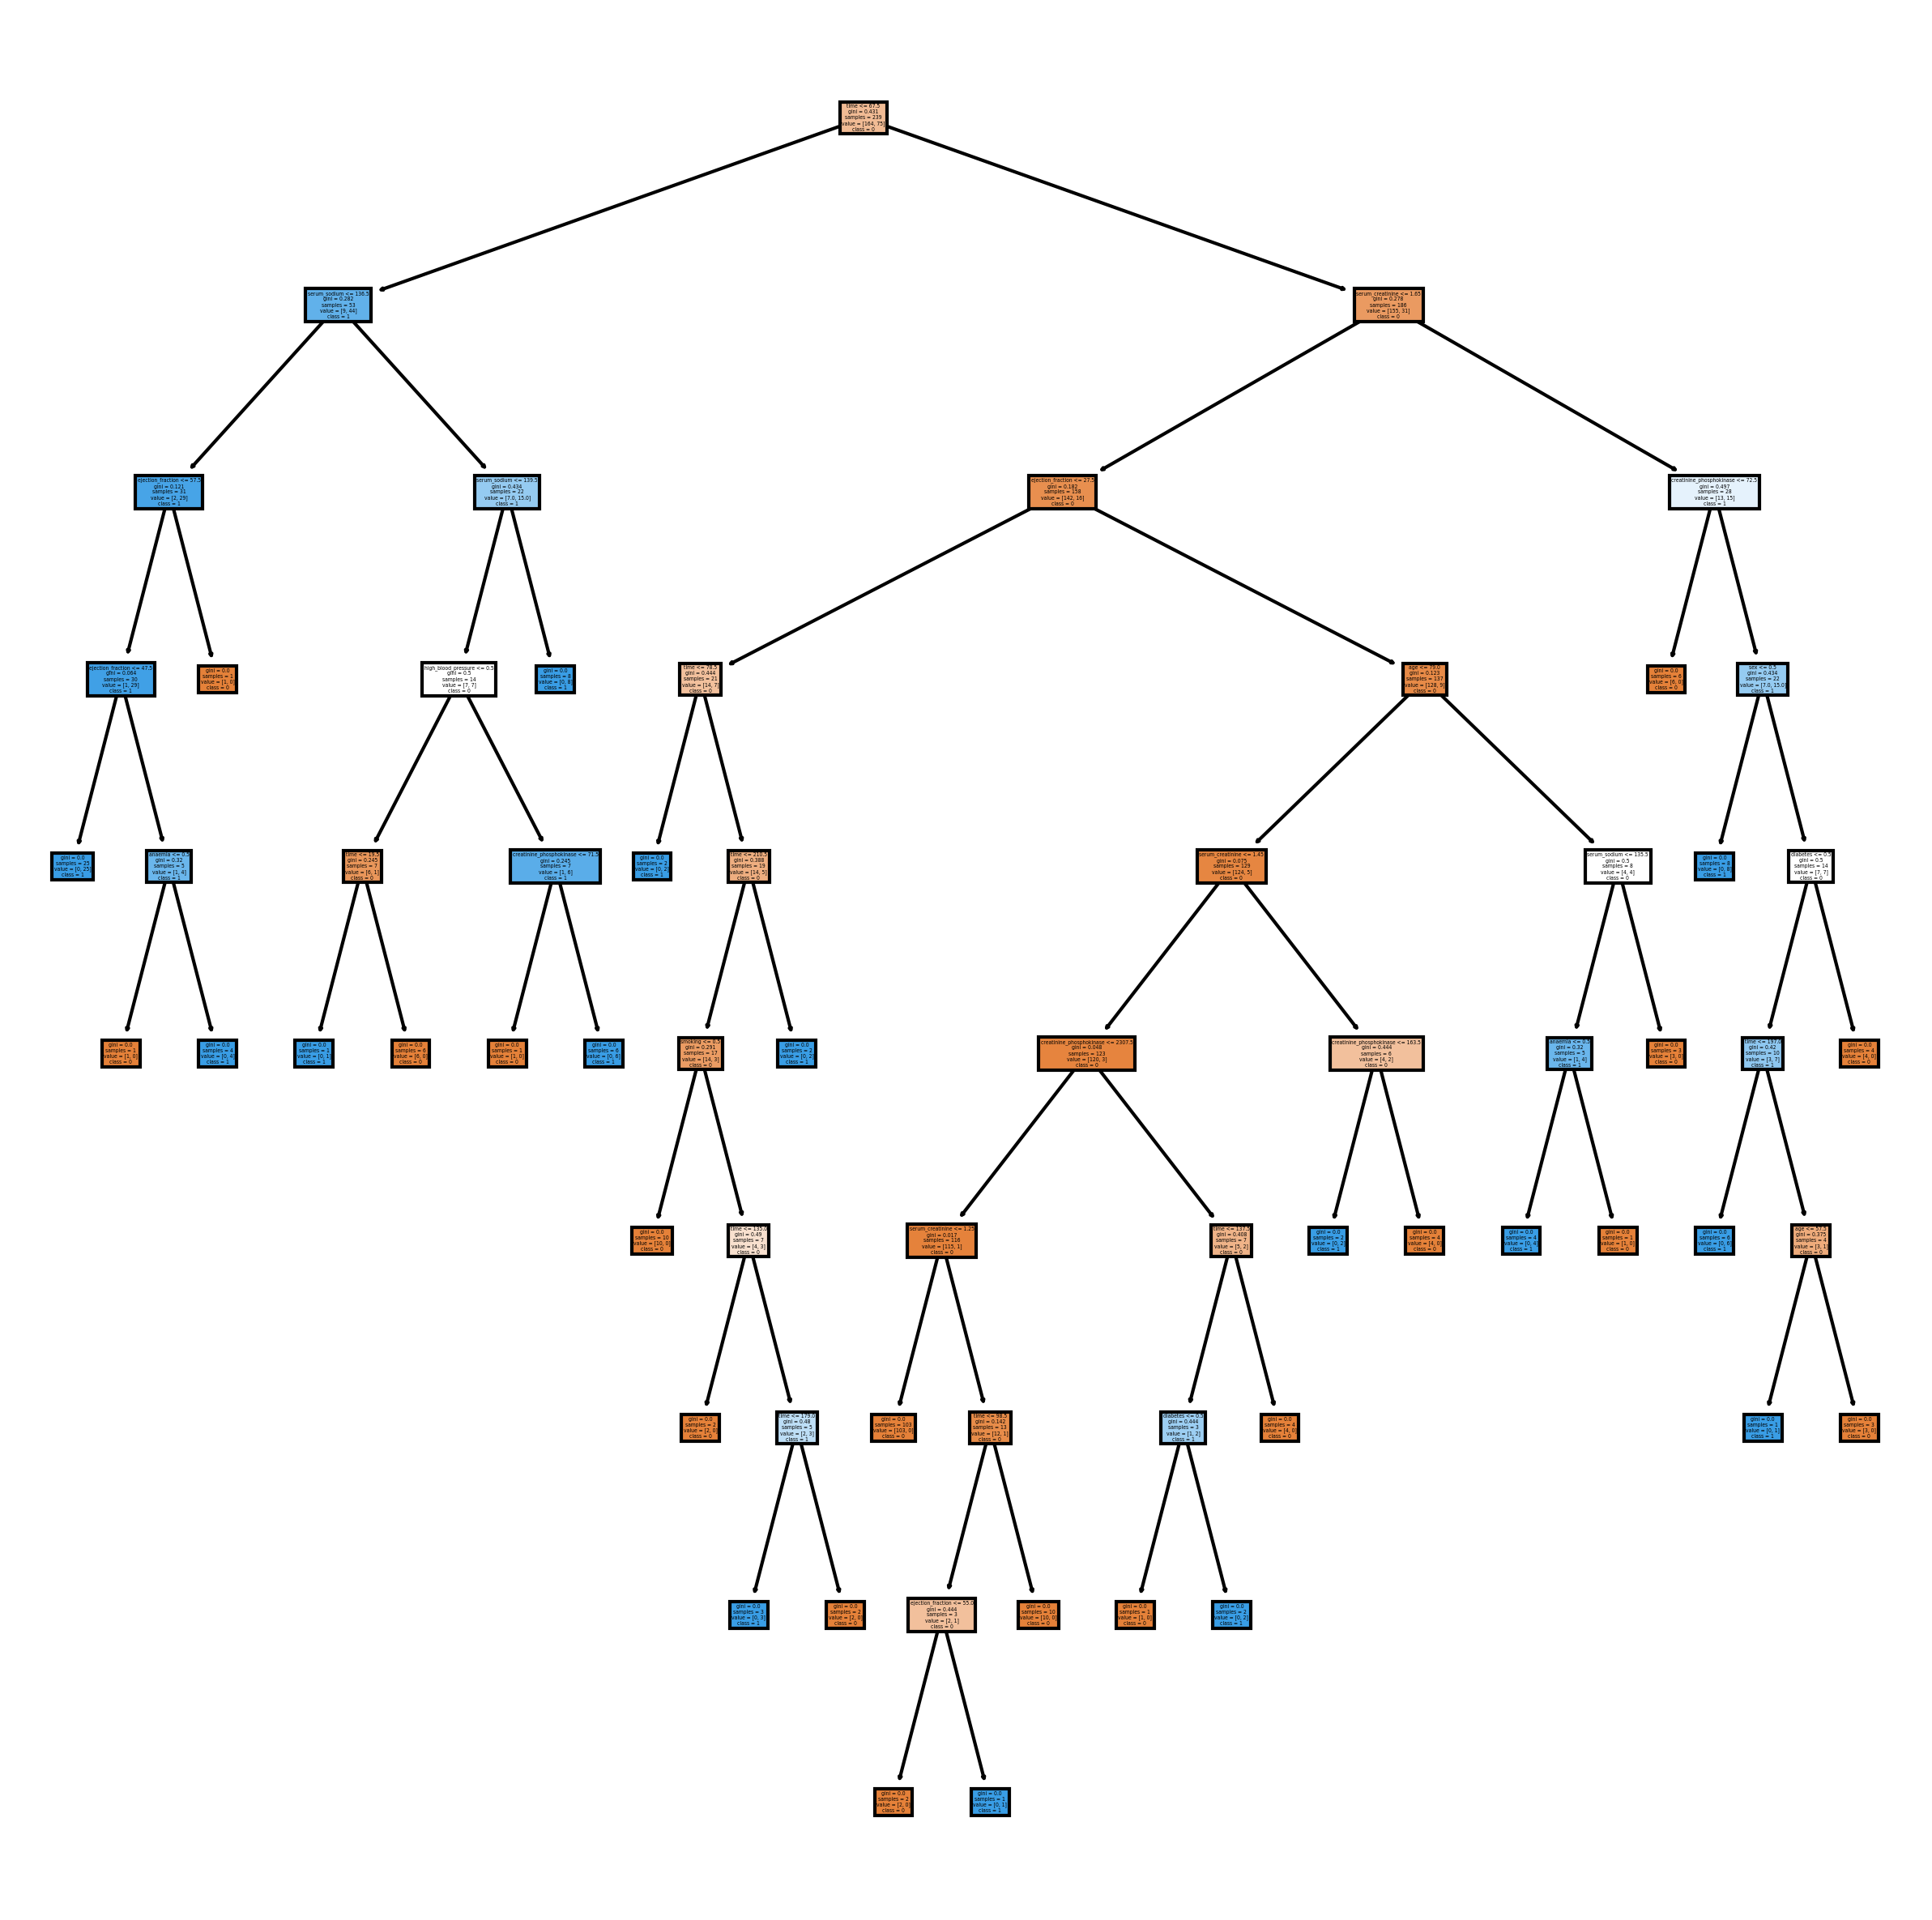

In [9]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10,10) , dpi = 300)
plot_tree(base_dt , filled = True ,
          feature_names = X_train.columns.tolist(),
          class_names = y_train.unique().astype(str).tolist()
          )
plt.show()

In [10]:
#Train Accuracy
X_train_pred = base_dt.predict(X_train)
print("Train Accuracy : " , accuracy_score(y_train , X_train_pred))

#Test Accuracy
X_test_pred = base_dt.predict(X_test)
print("Test Accuracy : " , accuracy_score(y_test , X_test_pred))

#CV Score
print("CV Score : " , cross_val_score(base_dt , X_train , y_train , cv = 5 , scoring = 'accuracy').mean())

Train Accuracy :  1.0
Test Accuracy :  0.8166666666666667
CV Score :  0.7700354609929078


**As this decision Tree is over fitted , FIne tuning and pruning needed**

**Pruning : Cutting the tree**

**what we can fine tune are:**
Criterion , max_depth , min_samples_split , min_samples_leaf , max_leaf_nodes =31 

In [13]:
from sklearn.model_selection import GridSearchCV

estimator = DecisionTreeClassifier()
params_grid = {'criterion' : ['gini' , 'entropy'] ,
               'max_depth' : list(range(1,11)),
              'min_samples_split' : [2,3,4,5] ,
              'max_leaf_nodes' : list(range(2,30))}

finetuned_model = GridSearchCV(estimator , params_grid , cv = 5 , scoring = 'accuracy')
finetuned_model.fit(X_train , y_train)

finetuned_model.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_leaf_nodes': 7,
 'min_samples_split': 3}

In [14]:
features = finetuned_model.best_estimator_.feature_importances_
features

array([0.05522277, 0.        , 0.07551924, 0.        , 0.04494579,
       0.        , 0.        , 0.15469749, 0.        , 0.0438571 ,
       0.        , 0.62575761])

In [15]:
Xtrain_updated = X_train.iloc[:,features > 0]
Xtest_updated = X_test.iloc[:,features > 0]

In [16]:
Xtrain_updated.columns.tolist()

['age',
 'creatinine_phosphokinase',
 'ejection_fraction',
 'serum_creatinine',
 'sex',
 'time']

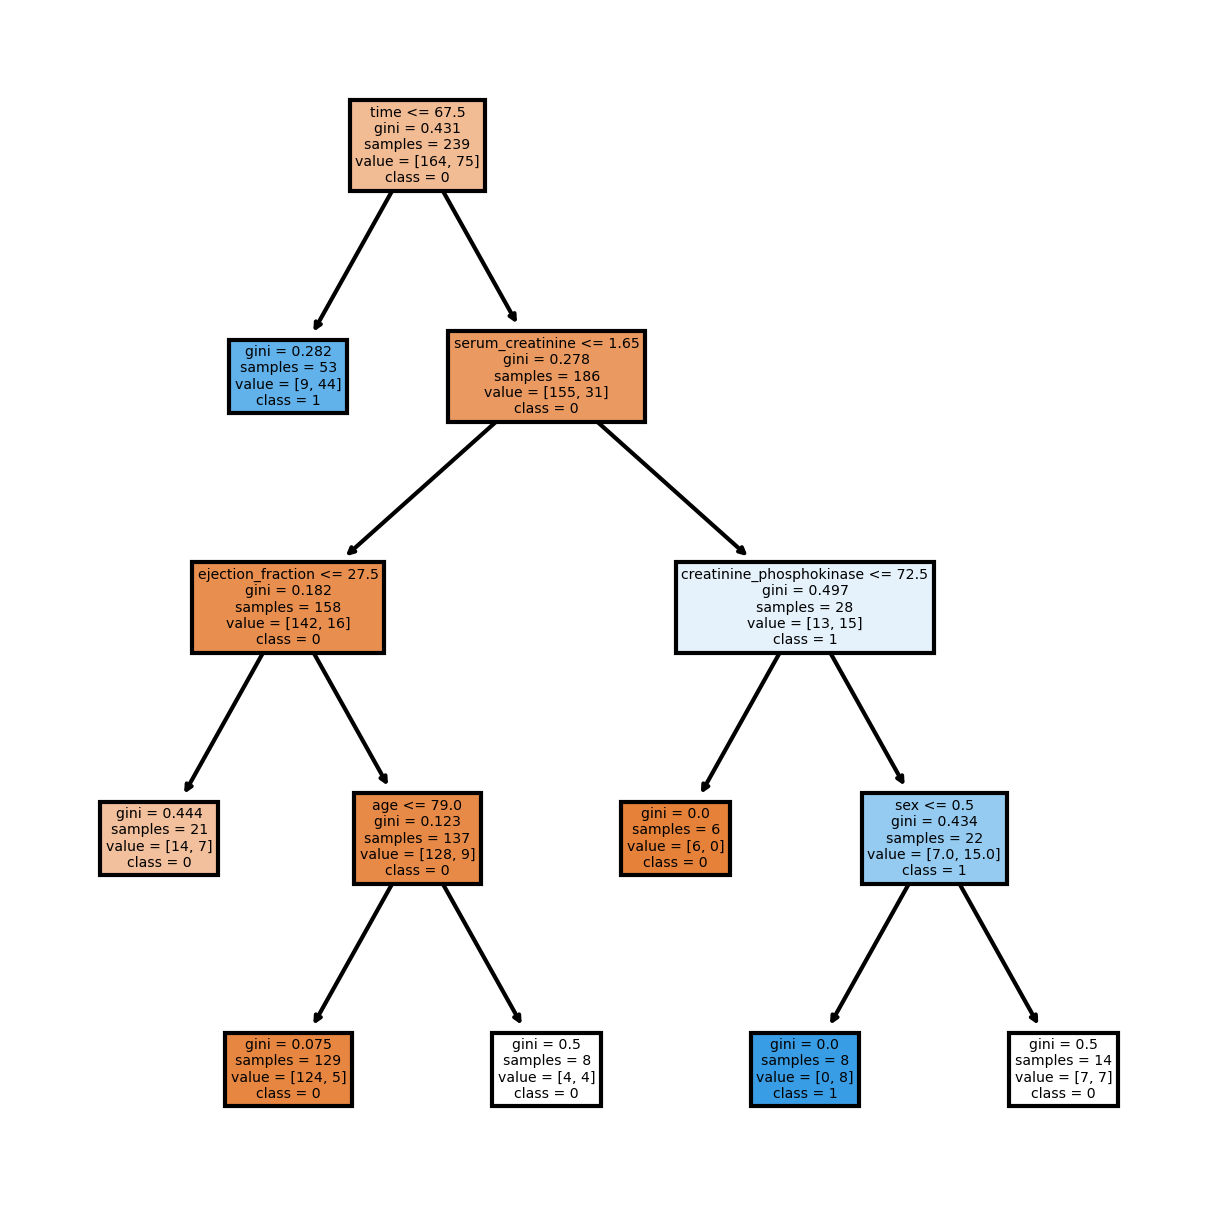

In [17]:
updated_dt = DecisionTreeClassifier(criterion = 'gini', max_depth = 7, max_leaf_nodes = 7, min_samples_split = 3)
updated_dt.fit(Xtrain_updated , y_train)

plt.figure(figsize=(5,5) , dpi = 300)
plot_tree(updated_dt , filled = True ,
          feature_names = Xtrain_updated.columns.tolist(),
          class_names = y_train.unique().astype(str).tolist()
          )
plt.show()

In [18]:
#Train Accuracy
X_train_pred = updated_dt.predict(Xtrain_updated)
print("Train Accuracy : " , accuracy_score(y_train , X_train_pred))

#Test Accuracy
X_test_pred = updated_dt.predict(Xtest_updated)
print("Test Accuracy : " , accuracy_score(y_test , X_test_pred))

#CV Score
print("CV Score : " , cross_val_score(updated_dt , Xtrain_updated , y_train , cv = 5 , scoring = 'accuracy').mean())

Train Accuracy :  0.8661087866108786
Test Accuracy :  0.8666666666666667
CV Score :  0.811790780141844


**Confusion Matrix**

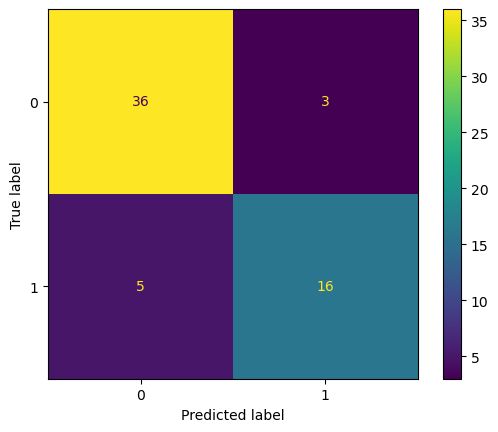

In [20]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

cm = confusion_matrix(y_test , X_test_pred)
ConfusionMatrixDisplay(cm , display_labels = [0,1]).plot()
plt.show()

**ROC Curve**

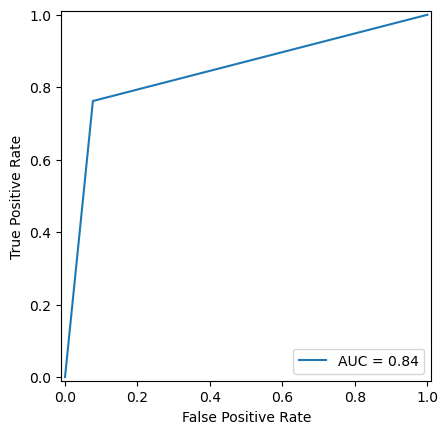

In [22]:
from sklearn.metrics import roc_curve , auc , RocCurveDisplay

fpr , tpr , threshold = roc_curve(y_test, X_test_pred)
roc_auc = auc(fpr , tpr)
RocCurveDisplay(fpr = fpr , tpr = tpr , roc_auc = roc_auc).plot()
plt.show()

In [23]:
from pickle import dump

In [24]:
dump(updated_dt, open('ml_model.pkl' , 'wb'))